# Credit Risk Analyst
Aleksander Jasiński


## Introduction

## Data loading

The imported data comes from https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

In [153]:
import pandas as pd


columns = [
    "checking_account", "duration", "credit_history", "purpose", "credit_amount",
    "savings_account", "employment_since", "installment_rate", "personal_status_sex",
    "other_debtors", "residence_since", "property", "age", "other_installment_plans",
    "housing", "number_credits", "job", "dependents", "telephone", "foreign_worker", "target"
]
df = pd.read_csv("data/german.data", sep=" ", names=columns)


In [154]:

print(df.isnull().sum(), df.shape)


checking_account           0
duration                   0
credit_history             0
purpose                    0
credit_amount              0
savings_account            0
employment_since           0
installment_rate           0
personal_status_sex        0
other_debtors              0
residence_since            0
property                   0
age                        0
other_installment_plans    0
housing                    0
number_credits             0
job                        0
dependents                 0
telephone                  0
foreign_worker             0
target                     0
dtype: int64 (1000, 21)


Posiadamy 1 000 obserwacji z 21 cechami, nie występują `missing_values`, konieczna będzie konwersja zmiennych nominalnych.

Nasz `target` to ostatnia kolumna, gdzie `1 = good credit` oraz `2 = bad credit`:


In [155]:
import numpy as np

np.unique(df["target"])

array([1, 2])

Dla klarowności przekonwertujmy zdolnośc kredytową na zmienną binarną"

In [156]:
df["target"] = np.where(df["target"]==1, 0,1)


# Exploratory Data Analysis

In [157]:
df.head(4)

,checking_account,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,dependents,telephone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0


In [158]:
df.describe()

,duration,credit_amount,installment_rate,residence_since,age,number_credits,dependents,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,0.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


Część zmiennych jest kategoryczna, tak jak zauważyliśmy już wcześniej w częśći **Preprocessing** będzie wymagany One Hot Encoding


Rozkład naszej zmiennej docelowej, czyli zdolności kredytowej, jest następujący:

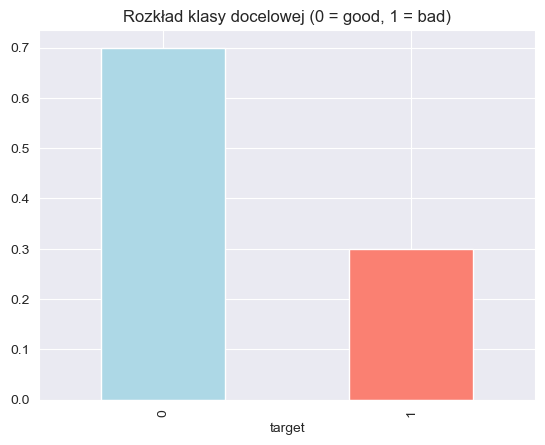

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt

df["target"].value_counts(normalize=True).plot(kind="bar", color=["lightblue","salmon"])
plt.title("Rozkład klasy docelowej (0 = good, 1 = bad)")
plt.show()

Około 70% klientów zarejestrowanych w naszej bazie `df` posiada dobrą zdolność kredytową.

Przejrzyjmy rozkład cech numerycznych za pomocą poniższego histogramu:

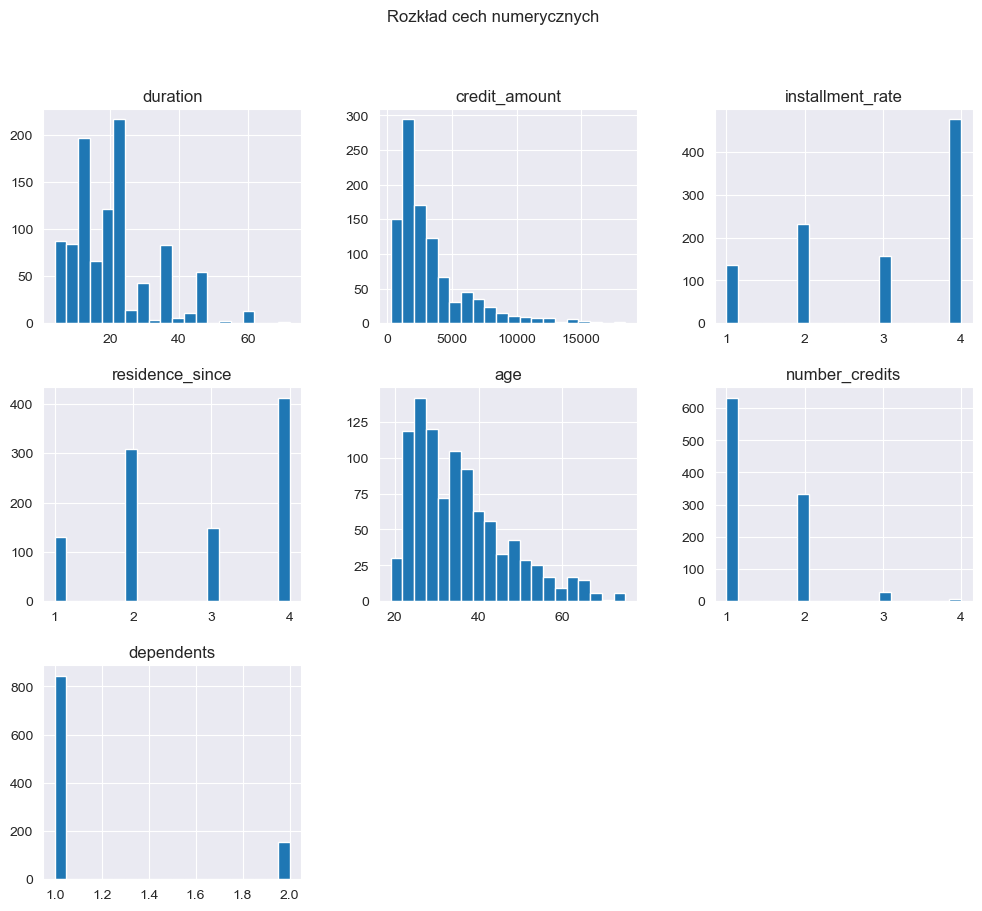

In [160]:
num_cols = ["duration", "credit_amount", "installment_rate", "residence_since", "age", "number_credits", "dependents"]

df[num_cols].hist(figsize=(12,10), bins=20)
plt.suptitle("Rozkład cech numerycznych")
plt.show()


* Większość kredytów to kredyty krótkoterminowe, przy `credit_amount` możemy zaobserwować długi ogon, w większośći mamy doczynienia z niskimi kredytami.
* Wiek klientów mieście się  w przedziale od 20 do 60 lat.
* Niewielka ilość klientów posiada więcej niż 2 kredyty, a zdecydowana większość wyłącznie jeden.

### Zaleźność (wybranych) cech numerycznych od zdolności kredytowej

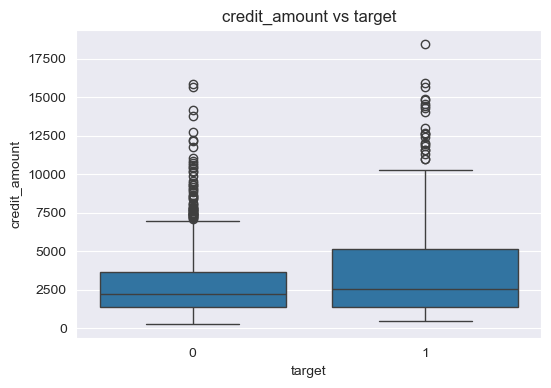

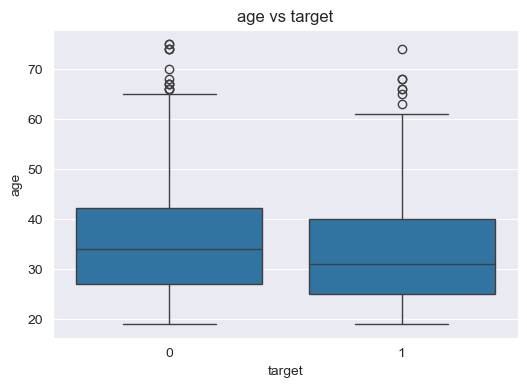

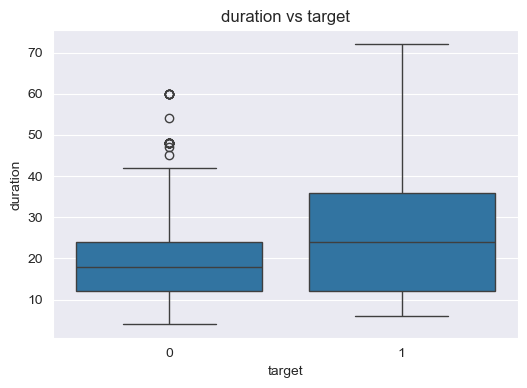

In [161]:
subgroup_col_numeric = ["credit_amount", "age", "duration"]
for col in subgroup_col_numeric:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="target", y=col, data=df)
    plt.title(f"{col} vs target")
    plt.show()


* Klienci, którzy mieli status „bad credit”, częściej zaciągali wyższe kwoty kredytu. Rozkład wartości w tej grupie jest bardziej zróżnicowany i zawiera więcej
* ekstremalnych wartości
* Osoby starsze mają skłonność do posiadana lepszej zdolności kredytowej niż osoby młodsze.
* Osoby z krótszymi kredytami mogą zazwyczaj wypracować lepszą zdolność kredytową niż osoby z kredytami długoterminowymi.


### Korelacja między zmiennymi kategorycznymi

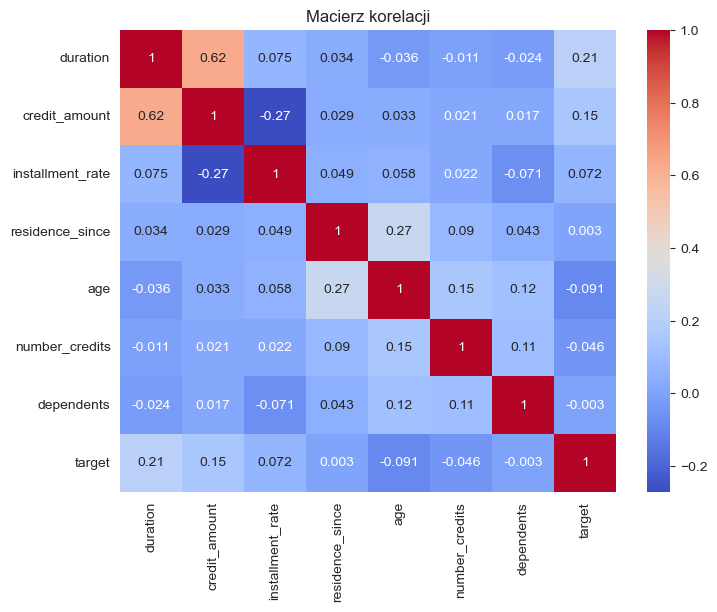

In [162]:
corr = df[num_cols + ["target"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Macierz korelacji")
plt.show()


Potwierdza się przypuszczenie, że młodsze osoby mają nieco większą skłonność do problemów ze spłatą. Poza tym, cecha `duration` jest najbardziej skorelowana z zdolnością kredytową (0.21), co sugeruje, że długość kredytu ma istotny wpływ na ryzyko, w cześci preprocessingu będziemy musieli uwzględnić fakt, że `duration` oraz `credit_amount` jest ze sobą silnie skorelowane (0.62).

## Preprocessing - encoding, scaling, split

In [163]:

cat_cols = ["checking_account", "credit_history", "purpose", "savings_account",
            "employment_since", "personal_status_sex", "other_debtors",
            "property", "other_installment_plans", "housing",
            "job", "telephone", "foreign_worker"]

y = df["target"] # let's map binary our values

X = df.drop("target", axis=1)

In [164]:
print(type(X))

<class 'pandas.core.frame.DataFrame'>


### Train/test split:

In [165]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13, stratify=y
)


### Encoding + scaling:

In [166]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),   # kolumny numeryczne
        ("cat", OneHotEncoder(drop="first"), cat_cols)  # kolumny kategoryczne
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

ohe = preprocessor.named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_features])





In [152]:
print(type(feature_names))
print(np.array(feature_names).shape)
print(type(feature_names[0]))
print(feature_names[:5])


<class 'numpy.ndarray'>
(48,)
<class 'str'>
['duration' 'credit_amount' 'installment_rate' 'residence_since' 'age']


## Assessing feature importance with random forests

In [167]:
from feature_importance_rf_model import FeatureImportanceRfModel

features_to_keep, X_train,X_test = FeatureImportanceRfModel(X_train_processed, y_train,X_test_processed, feature_names)



print(features_to_keep)

ValueError: Per-column arrays must each be 1-dimensional

The feature importance results from the Random Forest model reveal that the most influential predictors of credit risk are **credit amount, age, and loan duration**. These variables play a key role in distinguishing good and bad credit risks. Additionally, the presence or absence of a checking account also significantly impacts the model’s decisions. While many categorical features contribute moderately, some have minimal influence, suggesting they could be candidates for removal to simplify the model, as model showed we will only keep 24 of them.

## K-fold cross-validation

We are going to check it on LogisticRegression

In [140]:
X_train

,checking_account,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,other_debtors,residence_since,property,age,other_installment_plans,housing,number_credits,job,dependents,telephone,foreign_worker
255,A12,60,A33,A43,7418,A65,A73,1,A93,A101,1,A121,27,A143,A152,1,A172,1,A191,A201
673,A14,6,A34,A40,2080,A63,A73,1,A94,A101,2,A123,24,A143,A152,1,A173,1,A191,A201
120,A11,21,A32,A43,1835,A61,A73,3,A92,A101,2,A121,25,A143,A152,2,A173,1,A192,A201
141,A12,36,A32,A43,4795,A61,A72,4,A92,A101,1,A124,30,A143,A152,1,A174,1,A192,A201
350,A14,9,A32,A44,1236,A61,A72,1,A92,A101,4,A121,23,A143,A151,1,A173,1,A192,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,A11,12,A32,A42,1289,A61,A73,4,A93,A103,1,A122,21,A143,A152,1,A172,1,A191,A201
341,A11,21,A32,A42,3599,A61,A74,1,A92,A101,4,A123,26,A143,A151,1,A172,1,A191,A201
638,A14,12,A32,A43,1493,A61,A72,4,A92,A101,3,A123,34,A143,A152,1,A173,2,A191,A201
109,A12,14,A32,A49,1410,A63,A75,1,A94,A101,2,A121,35,A143,A152,1,A173,1,A192,A201


train_scores: [[nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]
test_scores: [[nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]


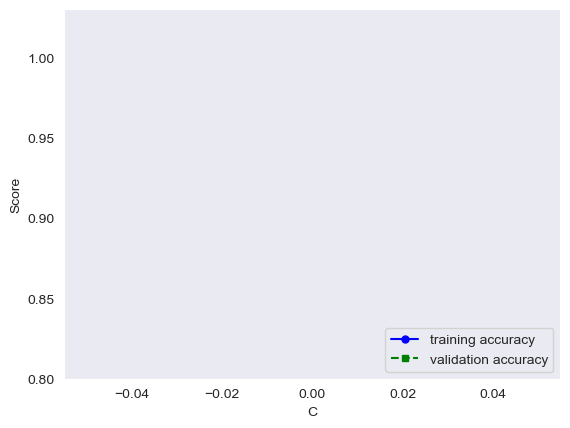

In [139]:
from k_cross_validation import k_cross_val_overfitting
from sklearn.linear_model import LogisticRegression
import k_cross_validation
import importlib
importlib.reload(k_cross_validation)

param_range = [0.001,0.01,0.1,1,10,100]
k_cross_val_overfitting(X_train, y_train, LogisticRegression(penalty="l2", random_state=1), "C", param_range)

# Model

Let's start with

In [31]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=13)


from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", model)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


## Binar classification via logistic regression:

[[124  16]
 [ 28  32]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       140
           1       0.67      0.53      0.59        60

    accuracy                           0.78       200
   macro avg       0.74      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200

ROC AUC: 0.8039285714285714


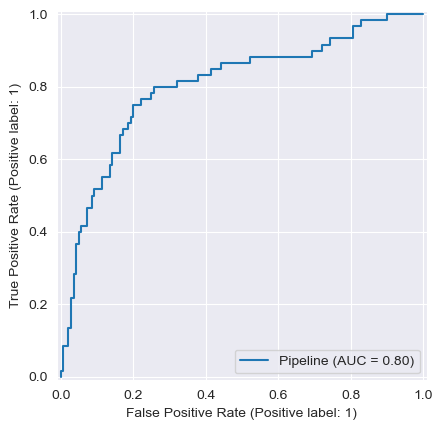

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1]))

RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()


The baseline logistic regression model **performs reasonably well**, reaching an overall accuracy of around 78%. It does a solid job at identifying customers with good creditworthiness, but it struggles more with the risky group, often failing to capture them correctly. The ROC AUC score of about _0.80_ suggests the model has a decent ability to separate the two classes, though there’s clear room for improvement. The imbalance between good and bad clients is likely affecting performance, especially for the minority class.

In practice, this means the model could already support basic credit risk assessment, but it would benefit from techniques like rebalancing the dataset or trying more advanced models such **as Random Forest or XGBoost**.

## Oversampling

# Logistic regression

In [36]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

lr_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=13)),
    ("classifier", LogisticRegression(max_iter=1000, random_state=13))
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:,1]


print("Logistic regression Results:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

Logistic regression Results:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       140
           1       0.57      0.80      0.67        60

    accuracy                           0.76       200
   macro avg       0.73      0.77      0.74       200
weighted avg       0.80      0.76      0.77       200

ROC AUC: 0.808452380952381


### Random Forest

In [33]:
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier


rf_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=13)),
    ("classifier", RandomForestClassifier(n_estimators=300, random_state=13))
    ])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:,1]

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       140
           1       0.65      0.43      0.52        60

    accuracy                           0.76       200
   macro avg       0.72      0.67      0.68       200
weighted avg       0.75      0.76      0.74       200

ROC AUC: 0.7823809523809524


The Random Forest model with oversampling showed an overall accuracy of around 76%, with very strong performance in detecting clients with good creditworthiness. However, its ability to identify **risky clients remains limited**, as recall for the minority class stayed relatively low. From **a banking perspective, this is a critical limitation** — while the model avoids misclassifying reliable borrowers, it may still approve too many clients with a high likelihood of default.

## XGBoost

In [35]:
from xgboost import XGBClassifier
xgb_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=13)),
    ("classifier", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        random_state=13,
        eval_metric="logloss"
    ))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:,1]

print("\nXGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))


XGBoost Results:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       140
           1       0.60      0.57      0.58        60

    accuracy                           0.76       200
   macro avg       0.71      0.70      0.70       200
weighted avg       0.75      0.76      0.75       200

ROC AUC: 0.795952380952381


The XGBoost model reached an overall accuracy of about 76% with an AUC close to 0.80, which indicates solid discriminatory power. Performance for the majority class (good clients) was strong, while **recall for risky clients improved compared to the baseline but remains below the level typically required** for reliable credit risk screening. From a banking perspective, **this suggests the model can be a valuable decision-support tool**, but further refinement — such as advanced hyperparameter tuning, cost-sensitive learning, or feature engineering — is necessary to minimize the risk of approving high-risk borrowers.